In [12]:
%%capture
!pip install flow-matching

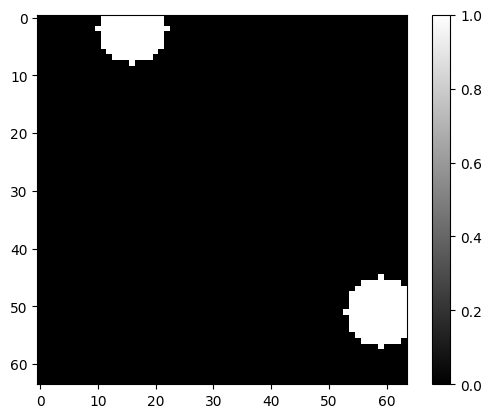

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
# from numpy.fft import fft2, ifft2
from torch.fft import fft2, ifft2, fftshift
im_size = 64
dataset = torch.load("dataset-lite.pt")
plt.imshow(dataset[10].squeeze(),cmap='gray')
plt.colorbar()
plt.show()

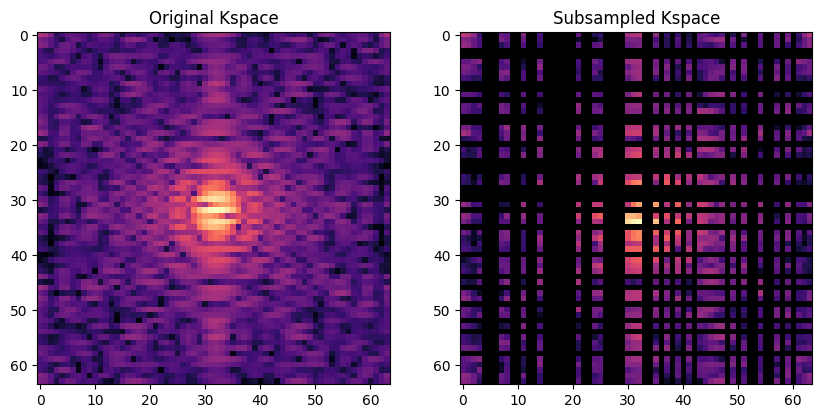

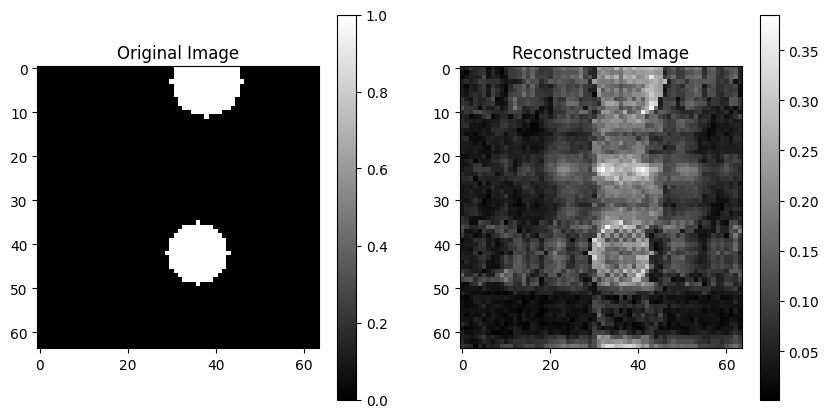

In [14]:
def unnormalize(samples):
    """Reverse [-1,1] scaling back to [0,1]"""
    return (samples + 1) / 2

def log_magnitude(x):
    return torch.log(1 + torch.abs(fftshift(x)))

def cartesian_mask(shape, center_fraction=0.08, accel_factor=4):
    """
    Cartesian undersampling mask for k-space.
    Keeps a low-frequency band and subsamples the rest uniformly.

    Args:
        shape (tuple): Image dimensions (H, W).
        center_fraction (float): Fraction of central k-space to keep (default 0.08).
        accel_factor (int): The factor by which to undersample the outer k-space (default 4).

    Returns:
        torch.Tensor: The undersampling mask.
    """
    H, W = shape
    mask = torch.zeros(H, W)

    # Keep the center (low frequency)
    center = int(W * center_fraction / 2)
    center_start = W // 2 - center
    center_end = W // 2 + center
    mask[:, center_start:center_end] = 1  # Keep low frequencies

    # Subsample outer frequencies
    for i in range(W):
        if i < center_start or i >= center_end:
            if torch.rand(1).item() < 1 / accel_factor:
                mask[:, i] = 1
    for i in range(H):
        if i < center_start or i >= center_end:
            if torch.rand(1).item() < 1 / accel_factor:
                mask[i, :] = 0

    return mask


image = dataset[15].squeeze(0)

plt.figure(figsize=(10, 5))
kspace = fft2(image)
plt.subplot(1, 2, 1)
plt.title("Original Kspace")
plt.imshow(log_magnitude(kspace), cmap='magma')
mask = cartesian_mask((im_size, im_size), center_fraction=0.1, accel_factor=2)
kspace_masked = kspace * mask
plt.subplot(1, 2, 2)
plt.title("Subsampled Kspace")
plt.imshow(log_magnitude(kspace_masked), cmap='magma')
plt.show()

image_reconstructed = torch.fft.ifft2(kspace_masked).abs()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title("Reconstructed Image")
plt.colorbar()

plt.show()


Using cpu.


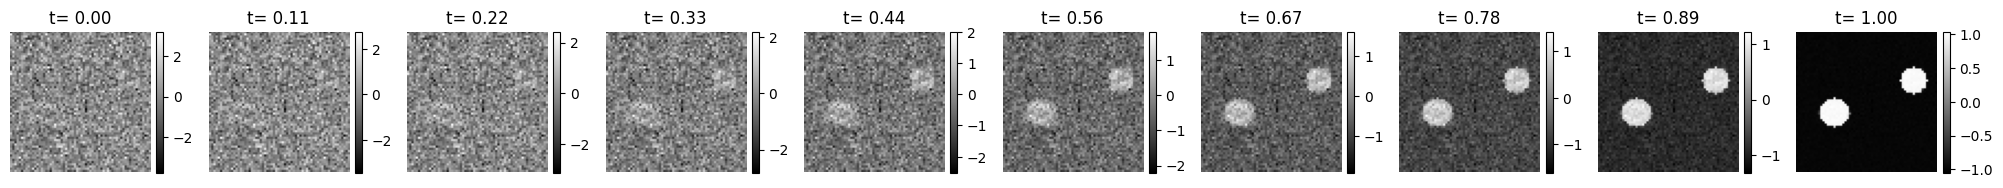

In [15]:
from flow_matching.utils import ModelWrapper
from flow_matching.solver import Solver, ODESolver
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn

im_size = 64

# Defined here so we can sample
class FourierEmbedding(nn.Module):
    def __init__(self, dim, scale=30.0):
        super().__init__()
        self.dim = dim
        self.scale = scale
        half_dim = dim // 2
        self.B = nn.Parameter(torch.randn(half_dim) *
                              scale, requires_grad=False)

    def forward(self, t):
        t = t.view(-1, 1)  # (batch_size, 1)
        proj = 2 * math.pi * t * self.B.unsqueeze(0)  # (batch_size, dim//2)
        embedding = torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        if self.dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding


class TimeResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, time_embed_dim):
        super().__init__()
        # Time conditioning
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, 2 * out_dim)
        )

        # Main block for 64x64 images
        self.block = nn.Sequential(
            nn.GroupNorm(8, in_dim),
            nn.SiLU(),
            nn.Conv2d(in_dim, out_dim, 3, padding=1),
            nn.GroupNorm(8, out_dim),
            nn.SiLU(),
            nn.Conv2d(out_dim, out_dim, 3, padding=1)
        )
        self.skip = nn.Conv2d(
            in_dim, out_dim, 1) if in_dim != out_dim else nn.Identity()

    def forward(self, x, t_embed):
        scale, shift = self.time_mlp(t_embed).chunk(2, dim=-1)
        h = self.block(x)
        h = h * (1 + scale[:, :, None, None]) + shift[:, :, None, None]
        return h + self.skip(x)


class VelocityField(nn.Module):
    def __init__(self, time_embed_dim=256, fourier_scale=100.0):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            FourierEmbedding(time_embed_dim, fourier_scale),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )

        # Encoder for 64x64 -> 32x32 -> 16x16
        self.down = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),    # 64x64x1 -> 64x64x64
            TimeResBlock(64, 64, time_embed_dim),
            nn.AvgPool2d(2),                   # 64x64x64 -> 32x32x64
            TimeResBlock(64, 128, time_embed_dim),
            nn.AvgPool2d(2)                    # 32x32x128 -> 16x16x128
        )
        # Bottleneck at 16x16
        self.mid = TimeResBlock(128, 128, time_embed_dim)

        # Decoder 16x16 -> 32x32 -> 64x64
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),       # 16x16x128 -> 32x32x128
            TimeResBlock(128, 64, time_embed_dim),
            nn.Upsample(scale_factor=2),       # 32x32x64 -> 64x64x64
            TimeResBlock(64, 64, time_embed_dim)
        )

        # Output layer (1 channel for grayscale)
        self.out = nn.Conv2d(64, 1, 3, padding=1)  # 64x64x64 -> 64x64x1

    def forward(self, x, t):
        # x: (B, 1, 64, 64), t: (B, 1)
        t_embed = self.time_embed(t)

        # Encoder
        h = self.down[0](x)
        for layer in self.down[1:]:
            if isinstance(layer, TimeResBlock):
                h = layer(h, t_embed)
            else:
                h = layer(h)

        # Bottleneck
        h = self.mid(h, t_embed)

        # Decoder
        for layer in self.up:
            if isinstance(layer, TimeResBlock):
                h = layer(h, t_embed)
            else:
                h = layer(h)

        return self.out(h)  # (B, 1, 64, 64)




if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')


# step size for ode solver
step_size = 0.008

#vf = torch.load("velocity_field.pt", weights_only=False, map_location=torch.device(device))
vf = torch.load("velocity_field.pt", weights_only=False, map_location=torch.device(device))

class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)


batch_size = 1  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
x_init = torch.randn(batch_size, 1, im_size, im_size, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
sol.shape
sol = sol.cpu()
T = T.cpu()

# Calculate the indices of the time steps to plot
num_plots = 10
plot_indices = np.linspace(0, len(T) - 1, num_plots, dtype=int)

# Create the figure and subplots
fig, axs = plt.subplots(1, num_plots, figsize=(20, 20))

# Iterate over the selected time steps and plot
for i, plot_index in enumerate(plot_indices):
    im = axs[i].imshow(sol[plot_index].squeeze(), cmap='gray')
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[plot_index]))  # Use the correct time value
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [16]:
dataset.shape

torch.Size([100, 1, 64, 64])

Now let us play with the noisy forward operator: Consider $A = P(\Lambda)T$ our DFT $T$ composed with our undersampling operator $P(\Lambda)$ (undersampled MRI). Then we will consider $$y = Ax + \varepsilon,$$ where $x$ is an image from our dataset, and $\varepsilon \sim N(0,I)$.

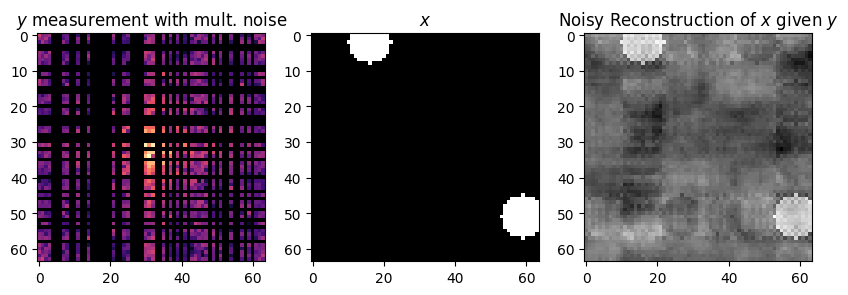

In [17]:
x = dataset[10]
# Experimenting
# Rescale x to [-1,1]
x = 2*x-1
eta = .35
y = fft2(x)*mask
y.shape
y = y*(1 + eta*torch.randn_like(y))
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
"""
axs[0].imshow(log_magnitude(fft2(x)*mask).squeeze(), cmap='magma')
axs[0].set_title('Undersampled Kspace of x')
"""
axs[0].imshow(log_magnitude(y).squeeze(), cmap='magma')
axs[0].set_title(r'$y$ measurement with mult. noise')
axs[1].imshow(x.squeeze(), cmap='gray')
axs[1].set_title(r'$x$')
axs[2].imshow(torch.real(ifft2(y).squeeze()), cmap='gray')
axs[2].set_title(r'Noisy Reconstruction of $x$ given $y$')
plt.show()

For now we will run the algorithm of FIG to solve our linear inverse problem.
Some code is made public by the authors [https://github.com/riccizz/FIG/blob/main/FIG_flow/sampler.py](https://github.com/riccizz/FIG/blob/main/FIG_flow/sampler.py)
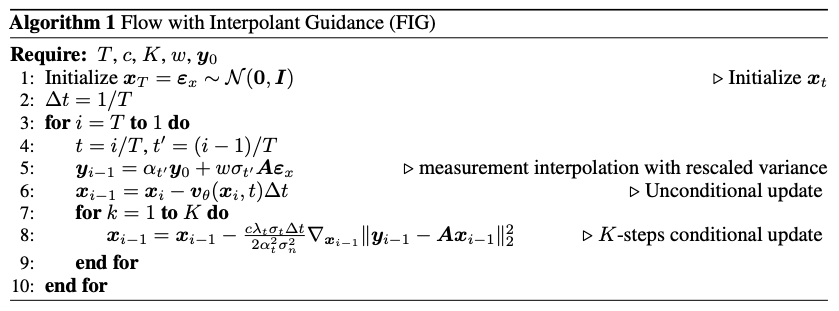

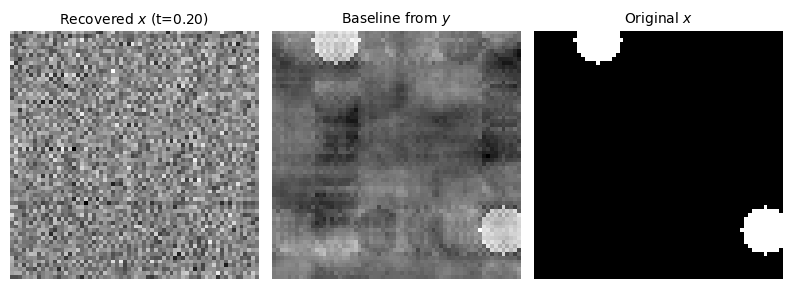

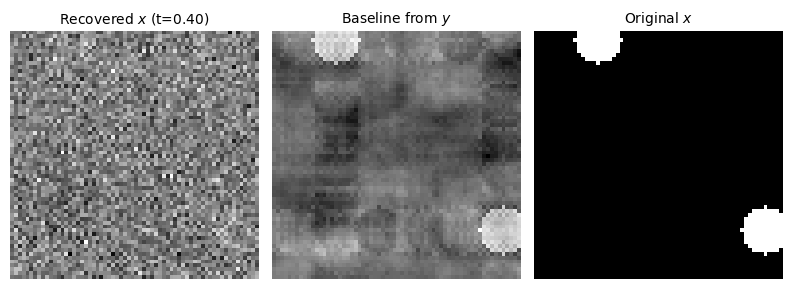

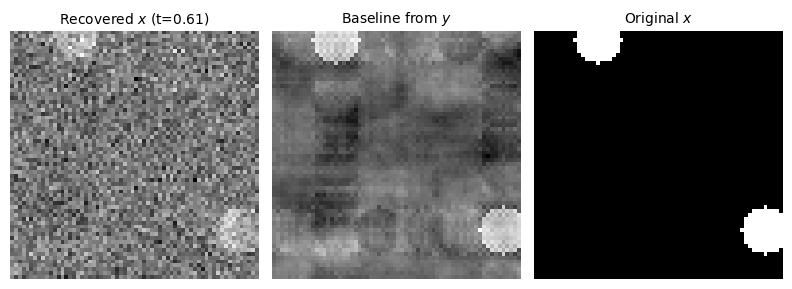

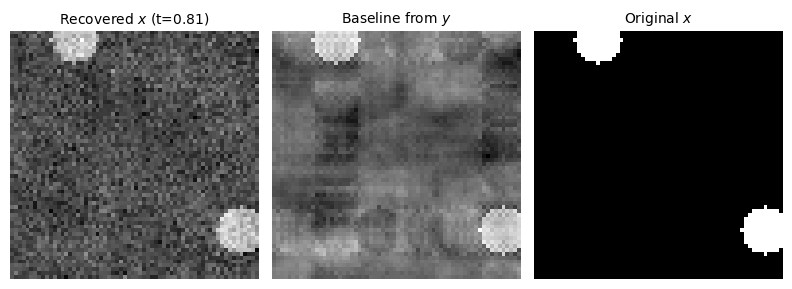

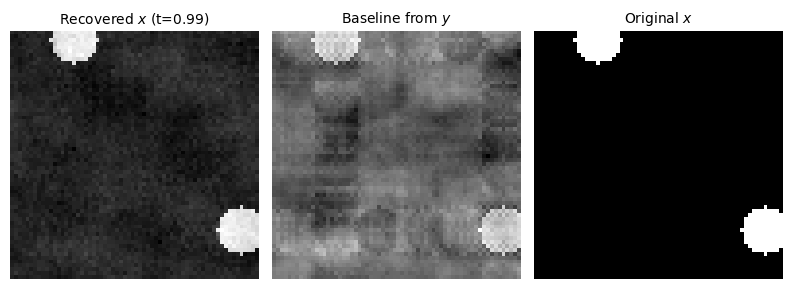

In [18]:
N = 100
T = torch.linspace(0,1,N, device=device)
x_T = torch.randn(1, 1, im_size, im_size, device=device)
x_T.requires_grad = False
x_curr = x_T.clone()
K = 1
y = y.to(device)
delta_t = 1/len(T)
mask = mask.to(device)
w = 1 # hyperparameter
c = 1 # hyperparameter meant to represent learning rate
# m = 1 # hyperparameter

for idx in range(1, len(T)-1):
    t = T[idx]
    t_next = T[idx+1]
    x_curr = x_curr.requires_grad_()
    x_next = x_curr + vf.forward(x_curr, t) * delta_t
    y_next = t_next * y + w * (1-t) * (fft2(torch.randn(1, 1, im_size, im_size, device=device)) * mask)

    if idx > 1 and idx != N - 1:
        for k in range(K):
            norm = torch.linalg.norm(y_next - fft2(x_next) * mask)
            grad = torch.autograd.grad(outputs=norm, inputs=x_next, retain_graph=True)[0]
            x_next = x_next - c * ((1 - t) / t) * grad
        x_curr = x_next

    if idx % 20 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # smaller figure
        y_cpu = y.to("cpu")
        x_curr_cpu = x_curr.to("cpu")
    
        axs[0].imshow(x_curr_cpu.detach().numpy().squeeze(), cmap="gray")
        axs[0].set_title(f"Recovered $x$ (t={t:.2f})", fontsize=10)
        axs[0].axis('off')
    
        axs[1].imshow(torch.real(ifft2(y_cpu)).squeeze(), cmap="gray")
        axs[1].set_title("Baseline from $y$", fontsize=10)
        axs[1].axis('off')
    
        axs[2].imshow(x.squeeze(), cmap="gray")
        axs[2].set_title("Original $x$", fontsize=10)
        axs[2].axis('off')
    
        plt.tight_layout(pad=1.0)
        plt.show()
fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # smaller figure
y_cpu = y.to("cpu")
x_curr_cpu = x_curr.to("cpu")

axs[0].imshow(x_curr_cpu.detach().numpy().squeeze(), cmap="gray")
axs[0].set_title(f"Recovered $x$ (t={t:.2f})", fontsize=10)
axs[0].axis('off')

axs[1].imshow(torch.real(ifft2(y_cpu)).squeeze(), cmap="gray")
axs[1].set_title("Baseline from $y$", fontsize=10)
axs[1].axis('off')

axs[2].imshow(x.squeeze(), cmap="gray")
axs[2].set_title("Original $x$", fontsize=10)
axs[2].axis('off')

plt.tight_layout(pad=1.0)
plt.show()



In [19]:
print(x_curr.max())
print(x.max())
y_ift = torch.real(ifft2(y))

tensor(1.0991, grad_fn=<MaxBackward1>)
tensor(1.)


In [20]:
d_l2_recov = torch.sqrt(torch.sum((x-x_curr)**2))/torch.sqrt(torch.sum(x**2))
d_l2_y_ift_recov = torch.sqrt(torch.sum((x-y_ift)**2))/torch.sqrt(torch.sum(x**2))

print(d_l2_recov)
print(d_l2_y_ift_recov)

tensor(0.1181, grad_fn=<DivBackward0>)
tensor(0.9667)


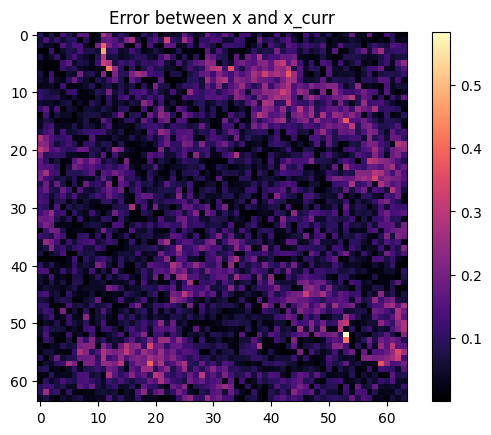

In [21]:
error = torch.abs(x_curr - x)  # Calculate the absolute difference between x and x_curr

plt.imshow(error.detach().numpy().squeeze(), cmap='magma')
plt.colorbar()
plt.title('Error between x and x_curr')
plt.show()

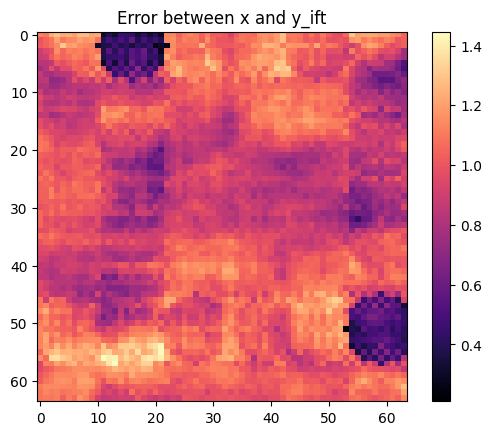

In [22]:
error = torch.abs(x - y_ift)  # Calculate the absolute difference between x and x_curr

plt.imshow(error.detach().numpy().squeeze(), cmap='magma')
plt.colorbar()
plt.title('Error between x and y_ift')
plt.show()